## import library

In [1]:
# Libraries
from typing import List, Tuple, Dict, Union, Any, Iterable, Optional

# root I/O
import uproot
import awkward as ak
import numpy as np
np.set_printoptions(threshold=np.inf)
# # plotting
import matplotlib.pyplot as plt
# from matplotlib.ticker import ScalarFormatter

# plotting style
import ROOT as r

# useful
import math
import sys
import os

Welcome to JupyROOT 6.30/02


## definition of constants

In [2]:
OUTPUT_DIR = "./../data/old_800mm_notar"
# debug data (100k events)
INPUT_ROOT_PATH = "/home/shiraiwa/myg4work/olddetector/old_800mm_taron/MT-build/develop_data/90k.root"
# 90k.root is development data
# 990k.root is true simulation data
# all data (60M events)
#INPUT_ROOT_PATH = "/home/shiraiwa/myg4work/olddetector/old_800mm_taron/MT-build/MT1/all.root"
VERVOSE = True
CHANNEL_PER_LAYER = 32
Y_MAX = 100
Z_POS = 2500
DIST_FR = 800
RESO_X = 32
RESO_Y = 32
MARGIN = 0
LIST_OF_BRANCHES = ['ScPosX','ScPosY','ScPosZ','ScEdep']


## definition of function

In [3]:
class EventFilter:
    """
    A class used to filter events from a ROOT file and convert to dict of numpy.ndarray.

    ...

    Attributes
    ----------
    input_root_path : str
        The path to the input ROOT file.
    output_dir : str
        The directory where the output will be stored.
    th_MeV : float
        The threshold energy in MeV for a channel to be considered active.
    events : dict
        The events data from the ROOT file.

    Methods
    -------
    _root_to_numpy():
        Converts the ROOT file to a numpy array.
    _correct_layer_order():
        Corrects the layer order of the events.
    _get_is_active_channel():
        Returns a boolean array indicating if the channel energy is > th_MeV.
    _filter_empty_events():
        Filters out events with no energy deposition.
    get_active_channel_idx():
        Returns a list of arrays with the channel indices of active channels.
    """
    def __init__(self, analysis_name:str, input_root_path:str, th_MeV:float=0.):
        """
        Constructs all the necessary attributes for the EventFilter object.

        Parameters
        ----------
            input_root_path : str
                The path to the input ROOT file.
            output_dir : str
                The directory where the output will be stored.
            th_MeV : float
                The threshold energy in MeV for a channel to be considered active.
        """
        self.analysis_name = analysis_name
        if not os.path.exists(self.analysis_name):
            os.makedirs(self.analysis_name)

        self.input_root_path = input_root_path
        self.th_MeV = th_MeV
        self.dist_fr = DIST_FR
        self.z_p = Z_POS
        self.reso_x = RESO_X
        self.reso_y = RESO_Y
        self.nbins = CHANNEL_PER_LAYER
        print("tring to read: ", self.input_root_path)
        self.events = self._root_to_numpy()
        print("success to read!")
        self.events = self._correct_layer_order()
        print("n_events before filter_empty_events(): ", len(self.events['ScEdep']))
        self.events = self._filter_empty_events()
        print("n_events after filter_empty_events(): ", len(self.events['ScEdep']))
        self.events = self._get_events_all_layer_passed()
        print("n_events after _get_events_all_layer_passed(): ", len(self.events['ScEdep']))
        self.hitchannels, self.hitmaps = self.get_hits()


    def _root_to_numpy(self)->Dict[str, np.ndarray]:
        """
        Convert root data to dictionary data of numpy.ndarray.

        Returns
        -------
        dict
            The events data with corrected layer order.
        """
        tree = uproot.open(self.input_root_path)["MT"]
        events = tree.arrays(LIST_OF_BRANCHES, library="np")
        for k in events.keys():
            # .keys() can show list of branches
            events[k] = np.stack(events[k], axis=0)
            # events have event_num * 128 np.array each LIST_OF_BRANCHES
        return events
    
    def _correct_layer_order(self)->Dict[str, np.ndarray]:
        """
        Corrects the layer order of the events from (0, 1, 2, 3) to (2, 3, 0, 1).

        Returns
        -------
        dict
            The events data with corrected layer order.
        """
        for k in self.events.keys():
            _layers = np.split(self.events[k], 4, axis=1)
            self.events[k] = np.concatenate([_layers[2], _layers[3], _layers[0], _layers[1]], axis=1)
        return self.events
    
    def _get_is_active_channel(self)->np.ndarray:
        """
        Returns a boolean array indicating if the channel energy is > th_MeV.

        Returns
        -------
        np.ndarray
            A boolean array where True indicates that the channel energy is > th_MeV.
        """
        is_active_channel = self.events['ScEdep'] > self.th_MeV
        # print("is_active_channel has type of ",type(is_active_channel))
        # print("is_active_channel has value of ",is_active_channel)
        return is_active_channel
    
    def _filter_empty_events(self)->np.ndarray:
        """
        Filters out events with no energy deposition.

        Returns
        -------
        np.ndarray
            The events data with empty events filtered out.
        """
        isnot_empty = (self.events['ScEdep']).sum(axis=1) > 0
        # isnot_empty has type of  <class 'numpy.ndarray'> and value of  [ True  True  True ...  True  True  True]
        # print("isnot_empty has type of ",type(isnot_empty))
        # print("isnot_empty has value of ",isnot_empty)
        # print("isnot_empty has value of ",isnot_empty.shape)
        for k in self.events.keys():
            self.events[k] = self.events[k][isnot_empty]
        return self.events
    
    # def get_active_channel_idx(self)->List[np.ndarray]:

    def _get_arrayed_events(self)->np.ndarray:
        """
        Returns a list of arrays with the channel index of active channels.

        Returns
        -------
        list
            A list index of channel number active channels for an event.
        """
        arrayed_events = []
        for k in self.events.keys():
            arrayed_events.append(self.events[k])
        return np.stack(arrayed_events, axis=-1)
    
    def get_active_channel_idx(self)->List[np.ndarray]:
        """
        Returns a list of arrays with the channel indices of active channels.

        Returns
        -------
        list
            A list of numpy arrays where each array contains the indices of the active channels for an event.
        """
        is_active_channel = self._get_is_active_channel()
        active_channel_idx = []
        for i in range(len(is_active_channel)):
            active_channel_idx.append(np.where(is_active_channel[i])[0])
        return active_channel_idx

    def _get_is_layers_passed(self)->np.ndarray:
        """
        Returns
        -------
        np.ndarray
            shape = (n_events, 4)
            A boolean array where True indicates that the channel energy is > th_MeV.
        """
        list_active_channel_idx = self.get_active_channel_idx()
        is_passed_layers = np.zeros(shape=(len(list_active_channel_idx), 4))
        # print(len(list_active_channel_idx), list_active_channel_idx[0])
        for e, active_channel_idx in enumerate(list_active_channel_idx):
            # active channel indexに0から31のいずれかの値が含まれているかどうか
            if np.isin(np.arange(32), active_channel_idx).any():
                is_passed_layers[e][0] = 1
            if np.isin(np.arange(32, 64), active_channel_idx).any():
                is_passed_layers[e][1] = 1
            if np.isin(np.arange(64, 96), active_channel_idx).any():
                is_passed_layers[e][2] = 1
            if np.isin(np.arange(96, 128), active_channel_idx).any():
                is_passed_layers[e][3] = 1
        return is_passed_layers

    def _get_events_idx_all_layer_passed(self)->np.ndarray:
        """
        Returns
        -------
        np.ndarray
            shape = (n_events, )
            A boolean array where True indicates that the channel energy is > th_MeV.
        """

        return self._get_is_layers_passed().sum(axis=1) == 4

    def _get_events_all_layer_passed(self)->Dict[str, np.ndarray]:
        """
        Returns
        -------
        Dict[str, np.ndarray]
        """
        for k in self.events.keys():
            self.events[k] = self.events[k][self._get_events_idx_all_layer_passed()]
        return self.events
   
    def get_channel_idx_for_split_array(self)->List[List[int]]:
        """
        Returns
        -------
        List[List[int]]
            shape = (n_events, 4, n_clusters, n_hits)
            A boolean array where True indicates that the channel energy is > th_MeV.
        """
        def _split_list(sorted_list: List[int], dividers: List[int]) -> List[List[int]]:
            import bisect
            dividers = sorted(dividers)
            result = []
            start = 0
            for divider in dividers:
                end = bisect.bisect_right(sorted_list, divider)
                result.append(sorted_list[start:end])
                start = end
            result.append(sorted_list[start:])
            return result

        active_channel_idx = self.get_active_channel_idx()
        dividers = [31, 63, 95]

        return [_split_list(sorted_list.tolist(), dividers) for sorted_list in active_channel_idx]

    def split_array(self,arr:list)->List[List[int]]:
        """
        Find consecutive hits.

        Parameters:
        arr: hit_pos_A or hit_pos_B from hit_finder function.

        Returns:
        An array of contiguous blocks of consecutive hit channels.

        Example:
        
        ```
        arr = [1,2,3,10,11,12,29,30]
        diff = [1,1,7,1,1,17,1]
        split_indices = [3,6] # This is the index that is not consecutive
        [array([1, 2, 3]), array([10, 11, 12]), array([29, 30])]
        ```

        """

        # for i in range(len(self.active_channel_idxs)):
        #     hit_pos_A_parent.append(self.active_channel_idxs[i][0])
        #     hit_pos_B_parent.append(self.active_channel_idxs[i][3])
        #     hit_pos_A_child.append(self.active_channel_idxs[i][1])
        #     hit_pos_B_child.append(self.active_channel_idxs[i][2])

        diff = np.diff(arr)
        split_indices = np.where(diff != 1)[0] + 1
        return np.split(arr, split_indices)

    def get_split_arrays(self)->List[List[List[int]]]:
        idx_for_split_array = self.get_channel_idx_for_split_array()
        for idx_event in range(len(idx_for_split_array)):
            for idx_layer in range(4):
                idx_for_split_array[idx_event][idx_layer] = self.split_array(idx_for_split_array[idx_event][idx_layer])
        return idx_for_split_array

    def get_split_events(self)->Dict[str, List[List[List[int]]]]:
        from tqdm import tqdm
        split_arrays = self.get_split_arrays()
        events = self.events

        if len(split_arrays) != len(events['ScEdep']):
            print("Error: length of get_split_arrays is not equal to length of events")
            print("len(split_arrays) = ", len(split_arrays))
            print("len(self.events['ScEdep']) = ", len(events['ScEdep']))
            sys.exit(1)

        dict_split_events = {}

        for key in events.keys():
            split_events = []
            for i in range(len(split_arrays)):
                split_events_layer = []
                for j in range(4):
                    split_events_layer_cluster = []
                    for k in range(len(split_arrays[i][j])):
                        # print(i,j,k)
                        # print('events[key][i]', events[key][i])
                        # print('split_arrays[i][j][k]',split_arrays[i][j][k])
                        split_events_layer_cluster.append(events[key][i][split_arrays[i][j][k]])
                    split_events_layer.append(split_events_layer_cluster)
                split_events.append(split_events_layer)
            dict_split_events[key] = split_events
        return dict_split_events

    def cal_centroid(self, clusters, edeps, mean):
        """
        Centroid is weighted value of hit channel. Weight is (hgadc-pedestal) and, values are caliculated in sellected channel in index.

        Parameters:
        index: list of consecutive hit channels from split_array. This array doesn't split event by event. 
        --- Example ---
        return from split_array = [array([1, 2, 3]), array([10, 11, 12]), array([29, 30])] ::event0
        return from split_array = [array([22, 23])] ::event1
        --> index[0] = [1,2,3], index[1] = [10,11,12], index[2] = [29,30], index[3] = [22,23]

        adc: high gain adc values of each channels, shape = 64 * n but only use adc[offset]
        mean: pedestal values of each channels, shape = 64.

        Returns:
        centroids 
            LIST of centroid position in each event.
        """
        centroids = []
        for cluster, edep in zip(clusters, edeps): # cluster loop
            # print(cluster, edep)
            centroid = np.average(cluster, weights=edep-mean)
            centroids.append(centroid)
        # print('centroids',centroids)
        return centroids

    def get_centroids(self):
        """
        Get centroids of all events.

        Parameters:
        adc: high gain adc values of each channels, shape = 64 * n but only use adc[offset]
        mean: pedestal values of each channels, shape = 64.

        Returns:
        centroids 
            LIST of centroid position in each event.
        """
        centroids = []
        split_arrays = self.get_split_arrays()
        split_events = self.get_split_events()

        for i in range(len(split_arrays)): # event loop
            centroids_i = []
            for j in range(4): # layer loop
                # print('i,j',i,j)
                # print('split_arrays[i][j]',split_arrays[i][j])
                # print('split_events[ScEdep][i][j]',split_events['ScEdep'][i][j])
                centroids_i.append(self.cal_centroid(split_arrays[i][j], split_events['ScEdep'][i][j], self.th_MeV))
            centroids.append(centroids_i)
        return centroids

    def get_hits(self):
        hitchannels = self.get_channel_idx_for_split_array()
        hitmaps = self.get_centroids()
        return hitchannels, hitmaps

    def getpos(self, x_f, y_f, x_r, y_r):
        """
        Caliculate intersection between plane and reconfigured line.
    
        Parameters:
        x_f: x position in front module
        y_f: y position in front module
        x_r: x position in rear module
        y_r: y position in rear module
        dist_fr: distance between front and rear modules
        z_p: position of projection plane

        Returns:
        x: x position in projection plane
        y: y position in projection plane
        z: z position in projection plane
        """
        dx = 10*(x_f - x_r)
        dy = 10*(y_f - y_r)
        rho = math.sqrt(dx**2 + dy**2)
        
        sin_theta = rho / math.sqrt(rho**2 + self.dist_fr**2)
        cos_theta = self.dist_fr / math.sqrt(rho**2 + self.dist_fr**2)
        cos_phi   = dx / rho if rho != 0 else 0
        sin_phi   = dy / rho if rho != 0 else 0
        return sin_theta * cos_phi * self.z_p / cos_theta + 10*x_r, sin_theta * sin_phi * self.z_p / cos_theta + 10*y_r, self.z_p


    def draw1Dhitchannel(self):
        # defnition of hit points in each layer
       
        layer1_hit_active_channel = r.TH1D("layer1 hit", "layer1 hit", self.nbins, 0, 32)
        layer2_hit_active_channel = r.TH1D("layer2 hit", "layer2 hit", self.nbins, 0, 32)
        layer3_hit_active_channel = r.TH1D("layer3 hit", "layer3 hit", self.nbins, 0, 32)
        layer4_hit_active_channel = r.TH1D("layer4 hit", "layer4 hit", self.nbins, 0, 32)

        canvas = r.TCanvas("canvas", "canvas", 800, 600)
        canvas.Divide(2,2)

        for hitchannel in self.hitchannels:
            # Front x
            #print("hitchannel in each event",hitchannel[0])
            for x1hit in hitchannel[0]:
                #print("claster have ",x1hit)
                # hits_x_in_front[int(x1hit)] += 1
                layer1_hit_active_channel.Fill(x1hit)

            # Front y
            for y1hit in hitchannel[1]:
                # hits_y_in_front[int(y1hit-self.nbins)] += 1
                layer2_hit_active_channel.Fill(y1hit-self.nbins)
            # Rear x
            for x2hit in hitchannel[2]:
                # hits_x_in_rear[int(x2hit-2.0*self.nbins)] += 1
                layer3_hit_active_channel.Fill(x2hit-2.0*self.nbins)
            # Rear y            
            for y2hit in hitchannel[3]:
                # hits_y_in_rear[int(y2hit-3.0*self.nbins)] += 1
                layer4_hit_active_channel.Fill(y2hit-3.0*self.nbins)
        
        canvas.cd(1)
        layer1_hit_active_channel.Draw()

        canvas.cd(2)
        layer2_hit_active_channel.Draw()

        canvas.cd(3)
        layer3_hit_active_channel.Draw()

        canvas.cd(4)
        layer4_hit_active_channel.Draw()

        canvas.Draw()
        canvas.SaveAs(self.analysis_name+"/"+"above_0Mev_channel_index_each_layer.png")

    def drawprojectionmap(self, accept_signle_hit_only=True, rotation=0.,numpy_plot=False):
        hitmaps = self.hitmaps
        dist_fr = self.dist_fr
        z_p = self.z_p
        reso_x = self.reso_x
        reso_y = self.reso_y

        xy_in_pp = []
        for i, hitmap in enumerate(hitmaps): # Loop for each event
            # Reject events with multiple hits
            if accept_signle_hit_only and (len(hitmap[0])!=1 or len(hitmap[1])!=1 or len(hitmap[2])!=1 or len(hitmap[3]) != 1):
                continue  
            # All possible combination
            for x1hit in hitmap[0]:
                for y1hit in hitmap[1]:
                    for x2hit in hitmap[2]:
                        for y2hit in hitmap[3]:
                            x, y, z = self.getpos(x1hit, y1hit-1.0*self.nbins, x2hit-2.0*self.nbins, y2hit-3.0*self.nbins)
                            xy_in_pp.append([x,y])
                            # if self.verbose:
                            #     print(i,":",x1hit, y1hit-1.0*self.nbins, x2hit-2.0*self.nbins, y2hit-3.0*self.nbins)
                            #     print("ANS", x, y, z)

        print('Total hit number is',len(xy_in_pp),'in',len(hitmaps),'events')

        # Plotting
        # convert to numpy
        xy_np = np.array(xy_in_pp)
        hist, x_edges, y_edges = np.histogram2d(xy_np[:, 0], xy_np[:, 1], bins=(reso_x, reso_y))
        # for debug
        # np.save("./hist.npy", hist)
        # np.save("./x_edges.npy", x_edges)
        # np.save("./y_edges.npy", y_edges)
        if numpy_plot == True:
            fig, axes = plt.subplots(1, 3, figsize=(24, 8))
            if abs(rotation) == 90.0:
                print('apply rotation',rotation)
                rotated_hist = np.rot90(hist)
                axes[0].imshow(rotated_hist.T, interpolation='nearest', origin='upper' if rotation > 0 else 'lower', extent=[y_edges[-1], y_edges[0], x_edges[0], x_edges[-1]])
                axes[0].set_xlabel('Y [mm]')
                axes[0].set_ylabel('X [mm]')
            elif abs(rotation) == 180.0:
                print('apply rotation',rotation)
                rotated_hist = np.rot90(hist)
                rotated_hist = np.rot90(rotated_hist)
                axes[0].imshow(rotated_hist.T, interpolation='nearest', origin='upper' if rotation > 0 else 'lower', extent=[x_edges[-1], x_edges[0], y_edges[-1], y_edges[0]])
                axes[0].set_xlabel('X [mm]')
                axes[0].set_ylabel('Y [mm]')
            elif abs(rotation) == 270.0:
                print('apply rotation',rotation)
                rotated_hist = np.rot90(hist)
                rotated_hist = np.rot90(rotated_hist)
                rotated_hist = np.rot90(rotated_hist)
                axes[0].imshow(rotated_hist.T, interpolation='nearest', origin='upper' if rotation > 0 else 'lower', extent=[x_edges[-1], x_edges[0], y_edges[-1], y_edges[0]])
                axes[0].set_xlabel('Y [mm]')
                axes[0].set_ylabel('X [mm]')
            else:
                if not rotation == 0.:
                    print('Invalid rotation of', rotation, 'ratation must be +-90.0, +-180.0, +-270.0.')
                # axes[0].imshow(hist.T, interpolation='nearest', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
                axes[0].imshow(hist.T, origin="lower", interpolation='nearest', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
                axes[0].set_xlabel('X [mm]')
                axes[0].set_ylabel('Y [mm]')

            axes[0].set_title('Hit map in Z='+str(z_p))

            axes[1].hist(xy_np[:, 0], bins=reso_x, range=[x_edges[0], x_edges[-1]])
            axes[1].set_title('X pos in Z='+str(z_p))
            axes[1].set_xlabel('X pos [mm]')
            axes[1].set_ylabel('number of hits')

            axes[2].hist(xy_np[:, 1], bins=reso_y, range=[y_edges[0], y_edges[-1]])
            axes[2].set_title('Y pos in Z='+str(z_p))
            axes[2].set_xlabel('Y pos [mm]')
            axes[2].set_ylabel('number of hits')

            # pp means Projection Plane
            plt.savefig(self.analysis_name+'/'+'hitmap_in_pp_2D.png')
            print('Save figure as', self.analysis_name+'/'+'hitmap_in_pp_2D.png')
            plt.show()

        # ROOT plot
        else:
            #draw 2D hist and projection hist
            hist_2d_projectionmap = r.TH2D("hist_2d_projectionmap", "hist_2d_projectionmap", 64, x_edges[0], x_edges[-1], 64, y_edges[0], y_edges[-1])
            hist_x = r.TH1F("hist_x", "X pos in Z=25000.", 64, x_edges[0], x_edges[-1])
            hist_y = r.TH1F("hist_y", "Y pos in Z=25000.", 64, y_edges[0], y_edges[-1])

            #fill hist
            for point in xy_in_pp:
                hist_2d_projectionmap.Fill(point[0], point[1])
                hist_x.Fill(point[0])
                hist_y.Fill(point[1])

            print("2D hist entries = ", hist_2d_projectionmap.GetEntries())

            #root option setting
            r.gStyle.SetOptStat(10)
            r.gStyle.SetPalette(1)
            outputfile = r.TFile(self.analysis_name+"/"+'hitmap_in_pp_2D.root', "RECREATE")

            #canvas setting
            canvas1 = r.TCanvas("canvas1", f"hitmap in Z={self.z_p}", 800, 600)
            canvas2 = r.TCanvas("canvas2", f"X pos in Z={self.z_p}", 800, 600)
            canvas3 = r.TCanvas("canvas3", f"Y pos in Z={self.z_p}", 800, 600)
      

            hist_2d_projectionmap.SetTitle("hitmap in Z=25000")
            hist_2d_projectionmap.GetXaxis().SetTitle("X [mm]")
            hist_2d_projectionmap.GetYaxis().SetTitle("Y [mm]")

            # canvas update and draw
            canvas1.cd()
            hist_2d_projectionmap.Draw("colz")           
            canvas1.SaveAs(self.analysis_name+"/"+"hitmap_2d_projectionmap.png")
            canvas1.Close()

            canvas2.cd()
            hist_x.Draw()
            canvas2.SaveAs(self.analysis_name+"/"+"hitmap_x.png")
            canvas2.Close()

            canvas3.cd()
            hist_y.Draw()
            canvas3.SaveAs(self.analysis_name+"/"+"hitmap_y.png")
            canvas3.Close()

            #write hist to root file
            hist_2d_projectionmap.Write()
            hist_x.Write()
            hist_y.Write()

            outputfile.Close()
            
            

## Execute part


In [4]:
event_filter = EventFilter(OUTPUT_DIR, INPUT_ROOT_PATH, th_MeV=0.0)

tring to read:  /home/shiraiwa/myg4work/olddetector/old_800mm_taron/MT-build/develop_data/990k.root
success to read!
n_events before filter_empty_events():  990000
n_events after filter_empty_events():  337168


KeyboardInterrupt: 

In [ ]:
hitmaps = event_filter.hitmaps

hitmap = hitmaps[0]

hitmap[0]

[8.0]

Total hit number is 27444 in 31601 events
Save figure as ./../data/old_800mm_notar/hitmap_in_pp_2D.png


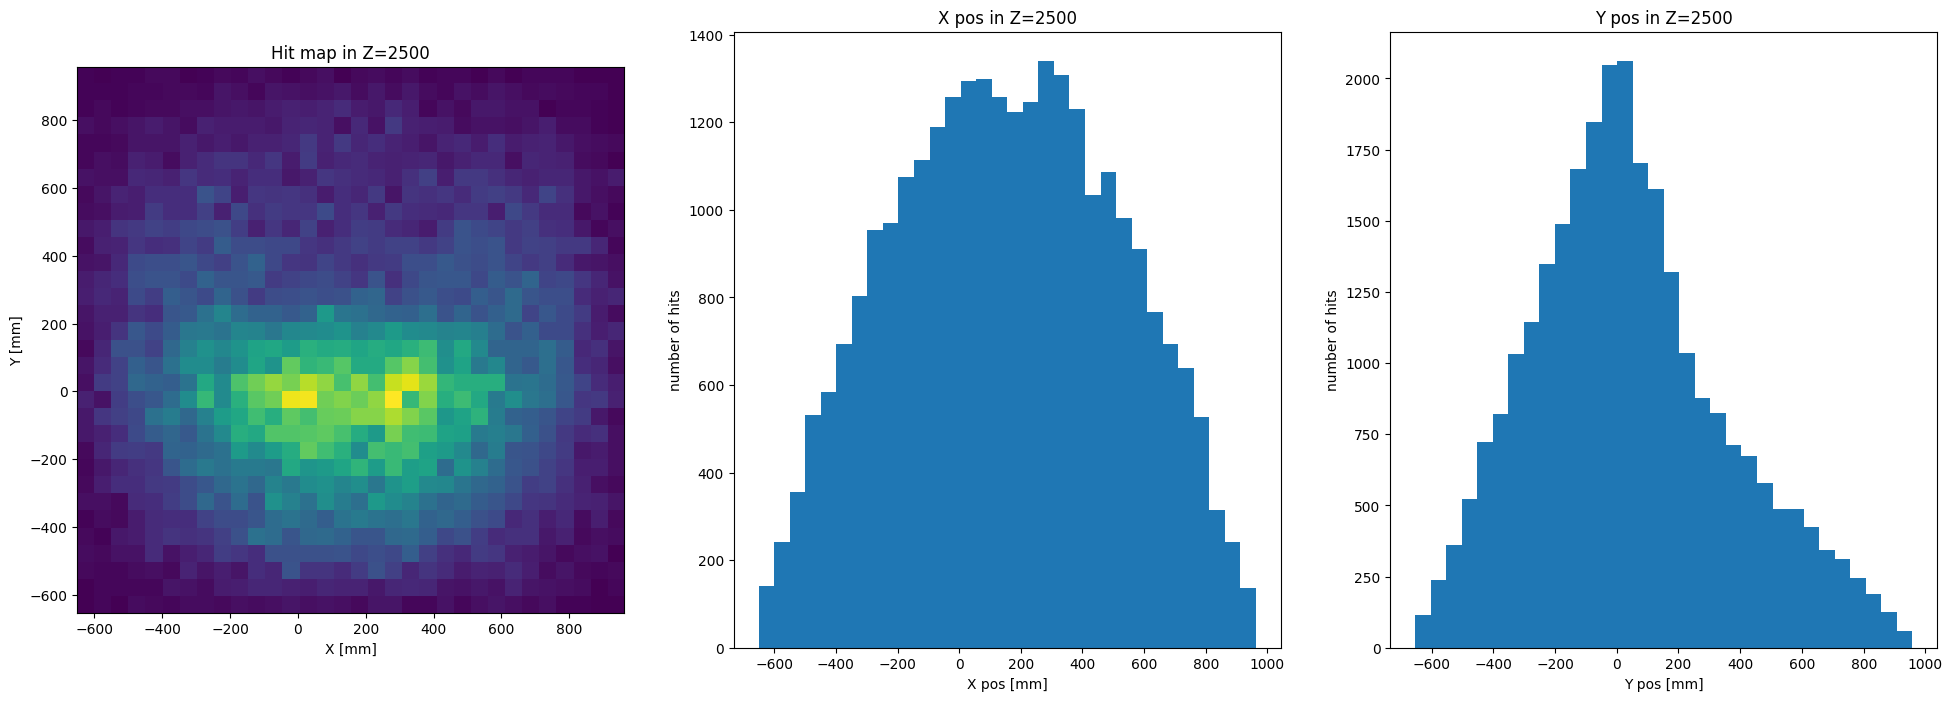

In [ ]:
event_filter.drawprojectionmap(rotation=0.0)